## 3 

作者 meelo

### 加载经过预处理的数据

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pickle_file = 'svhn_single.pickle'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    train_dataset = dataset['train_dataset']
    train_labels = dataset['train_labels']
    valid_dataset = dataset['valid_dataset']
    valid_labels = dataset['valid_labels']
    test_dataset = dataset['test_dataset'][:10000]
    test_labels = dataset['test_labels'][:10000]
    del dataset
    
print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)
print('Validing dataset shape: ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)
print('Testing dataset shape: ', test_dataset.shape)
print('Testing labels shape: ', test_labels.shape)

Training dataset shape:  (164594, 32, 32)
Training labels shape:  (164594,)
Validing dataset shape:  (8663, 32, 32)
Validing labels shape:  (8663,)
Testing dataset shape:  (10000, 32, 32)
Testing labels shape:  (10000,)


### 将数据修改成适合TensorFlow的格式

- 卷积要求图片数据的形状为(宽度×高度×通道数)
- 图片的标签需要进行1-hot编码，并转换成浮点数


![](./images/onehot.png)

In [3]:
print(train_labels[100:200])

[ 1  1 10  1  8  2  5  2  1  1  3  1  4  1  1  6  1  7  4  1  1  1  9  6  1
  3  5  5 10  7  9  2  1  3  9  3  8  4  3  1  5  1  5  5  1 10  1  1 10  4
  8  2  3  1  8  3  8  4  6  4  1  2  2 10  8  1  9  5  2  2  9  4  7  1  1
  3  5  4  1  2  6  4  3  3  5  2  4  5  6  1  4  2 10  3  2  2  1  1  4  3]


在原始数据中，数字1-9的标签是1-9，而数字0的标签是10。为了确保1-hot编码，表示是否为0的标签在第1列，应当使用语句`np.array([10,1,2,3,4,5,6,7,8,9]) == labels`。

将10替换成0
不然argmax不对应

In [4]:
IMAGE_SIZE = 32
NUM_LABELS = 10
num_channels = 1 # grayscale

In [5]:
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, num_channels)).astype(np.float32)
    #labels = (np.array([10,1,2,3,4,5,6,7,8,9]) == labels).astype(np.float32) # one-hot encoding
    labels[labels==10] = 0
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (164594, 32, 32, 1) (164594,)
Validation set (8663, 32, 32, 1) (8663,)
Test set (10000, 32, 32, 1) (10000,)


truncated normal  
soft max  
cross entroy loss  
regularizers  
learning rate decay
训练时dropout  
sparse  
随机梯度下降 Momumtum  
部分加载数据

In [7]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
NUM_HIDDEN = 128
SEED = 42

# BATCH_SIZE * 32 * 32 * 1
# conv1: 5 * 5 * 1 * 8
# BATCH_SIZE * 16 * 16 * 8
# conv2: 5 * 5 * 8 * 16
# BATCH_SIZE * 8 * 8 * 16
# conv3: 5 * 5 * 16 * 32
# BATCH_SIZE * 4 * 4 * 32
# fc1: 512 * 64
# BATCH_SIZE * 64
# fc2: 64 * 10 
# BATCH_SIZE * 10

In [14]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, num_channels))
    tf_train_labels = tf.placeholder(tf.int64, shape=(None,))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels, dtype=tf.int64)
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, num_channels, DEPTH_1], stddev=0.1))
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
    conv2_biases = tf.Variable(tf.zeros([DEPTH_2]))
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
    conv3_biases = tf.Variable(tf.zeros([DEPTH_3]))
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], stddev=0.1))
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    fc2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data, train=False):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [-1, shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        if train:
            hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
        return tf.matmul(hidden, fc2_weights) + fc2_biases
    
    def accuracy(predictions, labels):
        return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predictions, 1), labels), tf.float32)) * 100
    
    logits = model(tf_train_dataset, True)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) + tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases)
    loss += 5e-4 * regularizers
    
    batch = tf.Variable(0, dtype=tf.float32)
    #decayed_learning_rate = learning_rate *
    #                    decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay(
        0.01, # Base learning rate
        batch * BATCH_SIZE, # Current index into the dataset
        train_labels.shape[0], # Decay step
        0.95, # Decay rate,
        staircase=True
    )
    
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    
    train_accuracy = accuracy(train_prediction, tf_train_labels)
    valid_accuracy = accuracy(valid_prediction, tf_valid_labels)


训练后期，loss及准确率波动较大，应当使用学习率exponential decay

### 最佳模型
Validation accuracy: 83.5%  
Test accuracy: 82.5%

Validation accuracy: 88.1%  
Test accuracy: 87.6%

Validation accuracy: 90.8%
Test accuracy: 88.2%

Minibatch loss at step 10000: 0.354294, learning rate: 0.005404, 2.561s  
Minibatch accuracy: 93.8%  
Validation accuracy: 97.9%  
Test accuracy: 90.2%  

训练集使用过一次之后，随机打乱

In [9]:
def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [16]:
import time
import datetime

num_steps = 10001
SHOW_STATE_AFTER = 400

train_accuracies = []
valid_accuracies = []

best_valid_accuracy = 0
best_accuracy_step = 0
stop_after_step_no_progress = 4000

start_time = time.time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    offset = 0
    step = 0
    #for step in range(num_steps):
    while True:
        step += 1
        if(offset == 0):
            train_dataset, train_labels = shuffle_in_unison_inplace(train_dataset, train_labels)
            print('Random shuffle')
        feed_dict = {
            tf_train_dataset : train_dataset[offset:(offset + BATCH_SIZE)], 
            tf_train_labels : train_labels[offset:(offset + BATCH_SIZE)]
        }
        offset += BATCH_SIZE
        if offset+BATCH_SIZE > train_labels.shape[0]:
            offset = 0
        _, l, lr = session.run([optimizer, loss, learning_rate], feed_dict=feed_dict)
        if (step % SHOW_STATE_AFTER == 0):
            elapsed_time = time.time() - start_time
            start_time = time.time()
            train_acc, valid_acc = session.run([train_accuracy, valid_accuracy], feed_dict=feed_dict)

            improved_str = ''
            if valid_acc > best_valid_accuracy:
                saver.save(session, 'single20.ckpt', write_meta_graph=False)
                best_valid_accuracy = valid_acc
                best_accuracy_step = step
                improved_str = '*'
            
            train_accuracies.append(train_acc)
            valid_accuracies.append(valid_acc)
            print('Step %d, \tMinibatch loss %f, Learning rate: %.6f, Minibatch accuracy: %.2f%%, Validation accuracy: %.2f%% %s' % \
                  (step, l, lr, train_acc, valid_acc, improved_str))
            

            if step - best_accuracy_step > stop_after_step_no_progress:
                print("Valid accuracy makes no progress in {} steps".format(stop_after_step_no_progress))
                break

Initialized
Random shuffle
Step 400, 	Minibatch loss 1.072093, Learning rate: 0.010000, Minibatch accuracy: 73.44%, Validation accuracy: 82.86% *
Step 800, 	Minibatch loss 0.894000, Learning rate: 0.010000, Minibatch accuracy: 81.25%, Validation accuracy: 85.51% *
Step 1200, 	Minibatch loss 0.791554, Learning rate: 0.010000, Minibatch accuracy: 85.94%, Validation accuracy: 89.16% *
Step 1600, 	Minibatch loss 0.876993, Learning rate: 0.010000, Minibatch accuracy: 87.50%, Validation accuracy: 89.71% *
Step 2000, 	Minibatch loss 0.499205, Learning rate: 0.010000, Minibatch accuracy: 87.50%, Validation accuracy: 90.67% *
Step 2400, 	Minibatch loss 0.723080, Learning rate: 0.010000, Minibatch accuracy: 85.94%, Validation accuracy: 90.82% *
Random shuffle
Step 2800, 	Minibatch loss 0.505159, Learning rate: 0.009500, Minibatch accuracy: 89.06%, Validation accuracy: 91.68% *
Step 3200, 	Minibatch loss 0.595827, Learning rate: 0.009500, Minibatch accuracy: 82.81%, Validation accuracy: 91.61% 
S

### 学习曲线

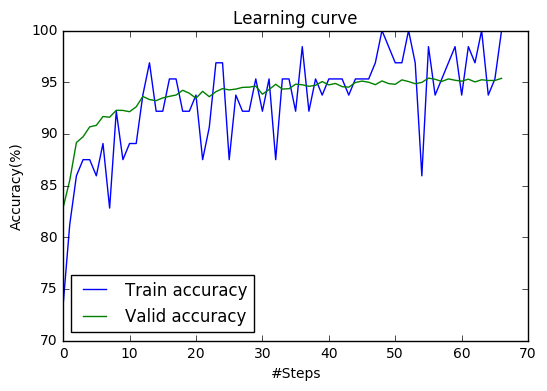

In [17]:
plt.plot(range(0, len(train_accuracies)), train_accuracies)
plt.plot(range(0, len(train_accuracies)), valid_accuracies)
plt.title('Learning curve')
plt.xlabel('#Steps')
plt.ylabel('Accuracy(%)')
plt.legend(['Train accuracy', 'Valid accuracy'], loc='best')